# MBTA Vehicle Updates
I've been archiving the output of the MBTA's realtime vehicle updates API and making it available for download from http://mbta-history.apptic.xyz. This notebook illustrates how to retrieve and use the data programmatically with Python 3 and Pandas.

In [1]:
from datetime import datetime, timedelta
from io import BytesIO, TextIOWrapper
import tarfile
from urllib.error import HTTPError
from urllib.request import urlopen

import numpy as np
import pandas as pd
import pytz

We'll define a function `get_updates` that takes a `datetime` argument and returns a pandas DataFrame containing all reported vehicle updates for that day (assuming they're available). You can also visit http://mbta-history.apptic.xyz directly, download the data for a particular day, then use `pandas.read_csv(path_to_csv_file)` to construct a dataframe.

In [2]:
def get_updates(dt):
    """Retrieves the vehicle updates for the given date from
    the archive site and read them into a pandas DataFrame.
    
    :param dt: a date-like object
    """
    # This reads the gzipped tarfile into memory, extracts the file,
    # and reads it directly into a dataframe.
    
    # Pandas can also read directly from URLs and file paths
    csv_filename = dt.strftime("%Y-%m-%d.csv")
    urlpref = dt.strftime("http://mbta-history.apptic.xyz/%Y/%m/" + csv_filename)
    
    try:
        return pd.read_csv(urlpref + ".gz", dtype="unicode")
    except HTTPError:
        filedata = BytesIO(urlopen(urlpref + ".tgz").read())
        with tarfile.open(mode="r:gz", fileobj=filedata) as tar:
            return pd.read_csv(tar.extractfile(csv_filename), dtype="unicode")

And let's retrieve the updates for yesterday:

In [3]:
now_utc = pytz.utc.localize(datetime.utcnow())
yesterday = now_utc.astimezone(pytz.timezone("US/Eastern")) - timedelta(days=1)

df = get_updates(yesterday)
df.drop_duplicates(inplace=True)
df.head()

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,lat,lon
0,36315571,2018-05-31,70035,180,O-5455E07B,IN_TRANSIT_TO,2018-05-31 01:59:39,42.40412902832031,-71.07698059082031
1,ADDED-1527664934,2018-05-31,70199,80,G-10378,STOPPED_AT,2018-05-31 01:59:43,42.3563117980957,-71.0627670288086
2,ADDED-1527664720,2018-05-31,70072,170,R-5455E5E4,IN_TRANSIT_TO,2018-05-31 01:59:08,42.36146926879883,-71.07437133789062
3,ADDED-1527664804,2018-05-31,70007,30,O-5455EB84,STOPPED_AT,2018-05-31 01:59:55,42.32318878173828,-71.09982299804688
4,ADDED-1527664758,2018-05-31,70012,130,O-5455EE02,INCOMING_AT,2018-05-31 01:59:35,42.34543991088867,-71.07865142822266


We can use the `DataFrame`'s `describe()` method to show summary statistics for each column.

In [4]:
desc = df.describe()
desc

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,lat,lon
count,970806,970806,969851,970806,970806,970806,970806,970806,970806
unique,17311,1,7994,154,1434,3,84023,94077,60971
top,CR-Weekday-Spring-18-925,2018-05-31,North Station,1,3001,STOPPED_AT,2018-05-31 13:06:22,42.34996032714844,-71.06456756591797
freq,687,970806,9674,122994,3263,378088,70,1235,1259


Note that pandas is treating all the columns as categorical columns. Instead of getting the median, mean, max (&c) that we might expect, we see the count of non-empty values (`count`); the number of unique values in each column; the most frequent value for each column (`top`); and the number of times the top column occurs (`freq`).

The reason is that when we imported the CVS file, we specified a dtype of `"unicode"`, which prevents pandas from inferring the type of every column. On this dataset, certain columns can look numeric (`vehicle_id`, `stop_id`) when they ought—according to the GTFS spec—to be treated as strings. 

(Note: if we knew the column types in advance, we could save a lot of memory by providing converters or types at import time. I prefer `"unicode"` for exploration, since it behaves predictably)

# Interlude: Vectorization
Operations on core pandas data structures like `DataFrame` are **vectorized**. That means, in general, that when you perform an operation on a structure, it is applied across that structure's elements. What that looks like concretely depends on the operator (or method) and the operands.

Let's see a few quick examples:

In [5]:
# 5 x 5 DataFrame of integers between 1-99
n_df = pd.DataFrame(np.random.randint(1, 100, size=(5, 5)), columns=list("abcde"))
n_df

,a,b,c,d,e
0,92,68,50,15,98
1,92,23,94,80,52
2,59,90,94,98,22
3,97,65,19,51,76
4,75,41,19,89,39


Adding two dataframes: element-wise addition **by index**.

In [6]:
n_df + pd.DataFrame(np.random.randint(1, 100, size=(5, 5)), columns=list("abcde"))

,a,b,c,d,e
0,108,75,117,37,188
1,138,100,170,84,81
2,67,151,192,155,120
3,172,137,29,74,144
4,122,91,90,108,71


Multiplying by a scalar:

In [7]:
5 * n_df

,a,b,c,d,e
0,460,340,250,75,490
1,460,115,470,400,260
2,295,450,470,490,110
3,485,325,95,255,380
4,375,205,95,445,195


Or comparison:

In [8]:
n_df > 50

,a,b,c,d,e
0,True,True,False,False,True
1,True,False,True,True,True
2,True,True,True,True,False
3,True,True,False,True,True
4,True,False,False,True,False


In [9]:
rvec = np.random.randint(1, 100, size=5)
print(rvec)
n_df * rvec

[64 31 11 57 46]


,a,b,c,d,e
0,5888,2108,550,855,4508
1,5888,713,1034,4560,2392
2,3776,2790,1034,5586,1012
3,6208,2015,209,2907,3496
4,4800,1271,209,5073,1794


Aggregation operations will reduce the dimensions.

By default, a dataframe applies functions across columns. You can change the axis using the `axis` parameter. `0` means columns, and `1` means rows.

In [10]:
n_df.sum()

a    415
b    287
c    276
d    333
e    287
dtype: int64

In [11]:
n_df.sum(axis=1)

0    323
1    341
2    363
3    308
4    263
dtype: int64

The generalization of applying an operation along an axis is the `apply` method.

In [12]:
n_df.apply(lambda column: column.sum())

a    415
b    287
c    276
d    333
e    287
dtype: int64

The generalization of applying an element-wise operation is `applymap`.

In [13]:
n_df.applymap((1000).__add__)

,a,b,c,d,e
0,1092,1068,1050,1015,1098
1,1092,1023,1094,1080,1052
2,1059,1090,1094,1098,1022
3,1097,1065,1019,1051,1076
4,1075,1041,1019,1089,1039


`Series` objects behave similarly.

In [12]:
a_column = n_df["a"]
a_column.sum()

191

In [13]:
# Adding two columns (Series with a shared index)
n_df["a"] + n_df["b"]

0    110
1     74
2     83
3    142
4     36
dtype: int64

In [14]:
# Or two rows (note that the index corresponds to the column names in the DataFrame)
n_df.loc[0] + n_df.loc[1]

a    106
b     78
c    127
d     86
e    123
dtype: int64

# Cleaning up
So, we can access an individual column as a `Series`:

In [14]:
df["stop_sequence"].head()

0    180
1     80
2    170
3     30
4    130
Name: stop_sequence, dtype: object

And we can get descriptive statistics for the column:

In [15]:
df["stop_sequence"].describe()

count     970806
unique       154
top            1
freq      122994
Name: stop_sequence, dtype: object

Or we can select a subset of the columns as a DataFrame:

In [16]:
df[["stop_sequence", "stop_id"]].head()

,stop_sequence,stop_id
0,180,70035
1,80,70199
2,170,70072
3,30,70007
4,130,70012


We can also replace a column in a DataFrame. 

For instance, we can convert the `stop_sequence` column, which is currently a string, to an integer column. ([spec](https://developers.google.com/transit/gtfs/reference/#stop_timestxt))

In [ ]:
df["stop_sequence"] = df.stop_sequence.astype(int)

And we can convert the coordinates to floats:

In [23]:
df[["lat", "lon"]] = df[["lat", "lon"]].astype(float)

If we then run `describe` again...

In [24]:
df.describe()

,stop_sequence,lat,lon
count,970806.000000,970806.000000,970806.000000
mean,55.887512,42.351366,-71.090982
std,123.992707,0.084675,0.092516
min,0.000000,41.581848,-71.882561
25%,4.000000,42.321014,-71.120842
50%,14.000000,42.349464,-71.085381
75%,32.000000,42.384666,-71.057800
max,680.000000,42.797241,-70.627190


... we **only** see a summary of the columns we've just cleaned up.

Pandas will, by default, summarize just the numerical columns of the DataFrame. Only if there are no numerical columns will it fall back to the behavior we saw previously.


## Timestamp Cleanup
Now let's clean up the `timestamp` column.

We imported the data from CSV, which doesn't have any standard representation for dates. We need to convert the string timestamps to datetimes that can be used in comparisons.

The recorded timestamps are in UTC. UTC doesn't observe DST, so a UTC timestamp unambiguously identifies a moment in time. But we're interested in Eastern time, EDT or EST, so we'll need to first turn the strings into UTC datetimes, then convert them into Eastern.

We'll put the resulting Series in a new column of the Dataframe.

(If you wanted to generalize this process to other systems that are not on Eastern time, you can use the `agency_timezone` field from `agencies.txt` in the [GTFS static feed](https://developers.google.com/transit/gtfs/reference/#agencytxt).)

In [25]:
df["local_timestamp"] = pd.to_datetime(df.timestamp, utc=True).dt.tz_convert("US/Eastern")
df.head()

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,lat,lon,local_timestamp
0,36315571,2018-05-31,70035,180,O-5455E07B,IN_TRANSIT_TO,2018-05-31 01:59:39,42.404129,-71.076981,2018-05-30 21:59:39-04:00
1,ADDED-1527664934,2018-05-31,70199,80,G-10378,STOPPED_AT,2018-05-31 01:59:43,42.356312,-71.062767,2018-05-30 21:59:43-04:00
2,ADDED-1527664720,2018-05-31,70072,170,R-5455E5E4,IN_TRANSIT_TO,2018-05-31 01:59:08,42.361469,-71.074371,2018-05-30 21:59:08-04:00
3,ADDED-1527664804,2018-05-31,70007,30,O-5455EB84,STOPPED_AT,2018-05-31 01:59:55,42.323189,-71.099823,2018-05-30 21:59:55-04:00
4,ADDED-1527664758,2018-05-31,70012,130,O-5455EE02,INCOMING_AT,2018-05-31 01:59:35,42.345440,-71.078651,2018-05-30 21:59:35-04:00


# Filtering

The MBTA's feed may publish more than one update for each trip and stop, because the position (lat/lng) and status may vary.

We can pick out just the updates that represent vehicle stops in a couple ways.

We can use a mask, or we can use the `.query()` method.

In [26]:
stops = df[df.status == "STOPPED_AT"] # mask
stops.head()

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,lat,lon,local_timestamp
1,ADDED-1527664934,2018-05-31,70199,80,G-10378,STOPPED_AT,2018-05-31 01:59:43,42.356312,-71.062767,2018-05-30 21:59:43-04:00
3,ADDED-1527664804,2018-05-31,70007,30,O-5455EB84,STOPPED_AT,2018-05-31 01:59:55,42.323189,-71.099823,2018-05-30 21:59:55-04:00
5,ADDED-1527664897,2018-05-31,70059,1,B-5455EBA6,STOPPED_AT,2018-05-31 01:56:23,42.413521,-70.991669,2018-05-30 21:56:23-04:00
8,ADDED-1527664892,2018-05-31,70117,270,G-10139,STOPPED_AT,2018-05-31 01:59:41,42.341591,-71.146378,2018-05-30 21:59:41-04:00
9,ADDED-1527664748,2018-05-31,70071,50,R-5455F00A,STOPPED_AT,2018-05-31 01:59:43,42.362431,-71.085808,2018-05-30 21:59:43-04:00


What's going on here?

Well, the equality comparison with `"STOPPED_AT"` is vectorized, so `df.status == "STOPPED_AT"` gives us back a `Series` containing `True` or `False` at each index. When you pass that Series inside square brackets to a dataframe, it acts as a filter.

In [31]:
stops = df.query("status == 'STOPPED_AT'") # query
stops.head()

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,lat,lon,local_timestamp
1,ADDED-1527664934,2018-05-31,70199,80,G-10378,STOPPED_AT,2018-05-31 01:59:43,42.356312,-71.062767,2018-05-30 21:59:43-04:00
3,ADDED-1527664804,2018-05-31,70007,30,O-5455EB84,STOPPED_AT,2018-05-31 01:59:55,42.323189,-71.099823,2018-05-30 21:59:55-04:00
5,ADDED-1527664897,2018-05-31,70059,1,B-5455EBA6,STOPPED_AT,2018-05-31 01:56:23,42.413521,-70.991669,2018-05-30 21:56:23-04:00
8,ADDED-1527664892,2018-05-31,70117,270,G-10139,STOPPED_AT,2018-05-31 01:59:41,42.341591,-71.146378,2018-05-30 21:59:41-04:00
9,ADDED-1527664748,2018-05-31,70071,50,R-5455F00A,STOPPED_AT,2018-05-31 01:59:43,42.362431,-71.085808,2018-05-30 21:59:43-04:00


# Merging
We have a `trip_id` column, but what we're often interested in is **routes**, not **trips**. The terminology is explained thoroughly in the [GTFS Reference](https://developers.google.com/transit/gtfs/reference/), but briefly, a trip is a collection of stops and times associated with a schedule and a route, and ordered by stop sequence.

So, the Red Line train to Ashmont leaving Alewife on non-holiday weekdays at 6:00 AM is a trip.

As you may have noted, the trip updates currently omit route_ids. In order to connect our trip_ids to route_ids, we have to join our vehicle update data to the static data provided by the MBTA.

To access the static data, we'll need to first define some additional functions.

The MBTA publishes the static schedule information in the form of a zipped directory of CSV files. (The files also include some other things we won't be using today, like fares). If you're curious about the full contents of the manifest, you can download the current one [here](http://www.mbta.com/uploadedfiles/MBTA_GTFS.zip) or read the [docs](https://developers.google.com/transit/gtfs/). For the purposes of this tutorial, we'll manipulate the zipfile in memory.

The MBTA updates the file several times a year, so you should be careful when analyzing historical data to retrieve the feed corresponding to the date(s) whose data you're viewing. We'll define a function `mbta_feed_url_for` that takes a datetime and returns the URL of the feed that was active on that date, based on the [list of archived feeds](https://www.mbta.com/gtfs_archive/archived_feeds.txt).

Below, we'll define `get_zip`, which we'll use to load a GTFS zip file from a URL into memory and `get_zip_item`, which will take a  zip and the name of an entry (`"agency"`, `"stops"`, etc.) and return a dataframe from the contents of the corresponding CSV file.

In [32]:
import csv
import zipfile

def mbta_feed_urls():
    """Returns a generator of (feed_start_date, feed_end_date, archive_url)
    tuples from the MBTA's archived feeds site.
    """
    u = urlopen("https://www.mbta.com/gtfs_archive/archived_feeds.txt")
    for l in csv.DictReader(TextIOWrapper(BytesIO(u.read()))):
        yield (datetime.strptime(l["feed_start_date"], "%Y%m%d"),
               datetime.strptime(l["feed_end_date"], "%Y%m%d"),
               l["archive_url"])

def mbta_feed_urls_for(range_start=None, range_end=None):
    eastern = pytz.timezone("US/Eastern")
    range_start = range_start or datetime.now()
    range_end = range_end or range_start
    for start, end, url in mbta_feed_urls():
        if range_start.tzinfo:
            start = start.astimezone(eastern)
            end = end.astimezone(eastern)
        if start <= range_end:
            if end < range_start:
                continue
            yield url
            
def mbta_feed_url_for(when):
    """Get the URL for the MBTA's GTFS feed active at the 
    datetime `when`."""
    return next(mbta_feed_urls_for(when, when), None)

def get_zip(url="http://www.mbta.com/uploadedfiles/MBTA_GTFS.zip"):
    with urlopen(url) as u:
        return zipfile.ZipFile(BytesIO(u.read()))
    
def get_zip_item(feed, name):
    data = TextIOWrapper(BytesIO(feed.read(name + ".txt")), 
                         encoding="utf-8", line_buffering=True)
    # Specify 'unicode' as the datatype so that Pandas
    # doesn't try to infer cell types. It will get it
    # wrong anyway.
    return pd.read_csv(data, dtype="unicode")

In [33]:
static_feed = get_zip(mbta_feed_url_for(yesterday))

Let's check out `trips.txt` first.

In [34]:
trips = get_zip_item(static_feed, "trips")
trips.head()

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,wheelchair_accessible,trip_route_type
0,Logan-22,Logan-Weekday,Logan-22-Weekday-trip,Loop,NaN,0,NaN,NaN,1,NaN
1,Logan-22,Logan-Weekend,Logan-22-Weekend-trip,Loop,NaN,0,NaN,NaN,1,NaN
2,Logan-33,Logan-Weekday,Logan-33-Weekday-trip,Loop,NaN,0,NaN,NaN,1,NaN
3,Logan-33,Logan-Weekend,Logan-33-Weekend-trip,Loop,NaN,0,NaN,NaN,1,NaN
4,Logan-55,Logan-Weekday,Logan-55-Weekday-trip,Loop,NaN,0,NaN,NaN,1,NaN


We want to match up the `trip_id` from each row in our `stops` DataFrame with a row in the `trips.txt` that has the same `trip_id` and add columns back into our data.

In Pandas, we do this with `pd.merge`. It's a lot like a **join** in SQL, and as with joins, there are a few different ways to do it, depending largely on how you want to handle rows for which there is no match.

We'll be using the default join method, namely `"inner"`, which will omit rows in both `stops` (our left-hand DataFrame) and `trips` (right-hand) for which there is no match.

Briefly, the other types of merge are:

`"left"`, which will preserve all rows in our left-hand DataFrame, and insert nulls for the new columns when there is no match. We'll usually find a few unknown trip_ids in `stops`, if there's a detour, for instance, or track work.

`"right"`, predictably, preserves all the rows in our left-hand DataFrame. Because we're looking at data for one day, there will be more trips in `trips.txt` that we won't see in `stops`. Some trips run only on weekdays, or holidays, or Fridays, and so on.

And `"outer"` just preserves everything.

In [36]:
stops_with_routes = pd.merge(stops, trips[["trip_id", "route_id", "direction_id"]], on="trip_id")
stops_with_routes.head()

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,lat,lon,local_timestamp,route_id,direction_id
0,36315571,2018-05-31,70035,180,O-5455E07B,STOPPED_AT,2018-05-31 02:02:36,42.426682,-71.074280,2018-05-30 22:02:36-04:00,Orange,1
1,36315571,2018-05-31,70001,1,O-5455F14D,STOPPED_AT,2018-06-01 01:33:32,42.301189,-71.113762,2018-05-31 21:33:32-04:00,Orange,1
2,36315571,2018-05-31,70003,10,O-5455F14D,STOPPED_AT,2018-06-01 01:45:58,42.310009,-71.107819,2018-05-31 21:45:58-04:00,Orange,1
3,36315571,2018-05-31,70005,20,O-5455F14D,STOPPED_AT,2018-06-01 01:47:40,42.316818,-71.104431,2018-05-31 21:47:40-04:00,Orange,1
4,36315571,2018-05-31,70007,30,O-5455F14D,STOPPED_AT,2018-06-01 01:49:27,42.323189,-71.099823,2018-05-31 21:49:27-04:00,Orange,1


In [37]:
stops_info = get_zip_item(static_feed, "stops")
stops_info.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,wheelchair_boarding
0,Wareham Village,NaN,Wareham Village,NaN,41.758333,-70.714722,NaN,NaN,0,NaN,1
1,Buzzards Bay,NaN,Buzzards Bay,NaN,41.744805,-70.616226,NaN,NaN,0,NaN,1
2,Hyannis,NaN,Hyannis,NaN,41.660225,-70.276583,NaN,NaN,0,NaN,1
3,Logan-E,NaN,Logan Airport Terminal E,NaN,42.370022,-71.020754,NaN,NaN,0,NaN,1
4,Logan-Subway,NaN,Airport Subway Station,NaN,42.374699,-71.029831,NaN,NaN,0,place-aport,1


In [47]:
named_stops = pd.merge(stops_with_routes.drop(["lat", "lon", "timestamp", "status"], axis=1), 
                       stops_info[["stop_id", "stop_name"]], on="stop_id")
named_stops.head()

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,local_timestamp,route_id,direction_id,stop_name
0,36315571,2018-05-31,70035,180,O-5455E07B,2018-05-30 22:02:36-04:00,Orange,1,Malden - Outbound
1,36315606,2018-05-31,70035,180,O-5455E542,2018-05-31 01:25:26-04:00,Orange,1,Malden - Outbound
2,36315541,2018-05-31,70035,180,O-5455EBB3,2018-05-31 06:11:55-04:00,Orange,1,Malden - Outbound
3,36315553,2018-05-31,70035,180,O-5455EE02,2018-05-31 06:25:23-04:00,Orange,1,Malden - Outbound
4,36315483,2018-05-31,70035,180,O-5455EB87,2018-05-31 06:34:23-04:00,Orange,1,Malden - Outbound


# Vehicle Clusters

In [48]:
named_stops.sort_values("local_timestamp", inplace=True)
red_line = named_stops.query("route_id == 'Red'")
orange_line = named_stops.query("route_id == 'Orange'")
blue_line = named_stops.query("route_id == 'Blue'")

In [49]:
# Group by stop_id and direction_id?

rl_grouped = red_line.groupby(["stop_id", "direction_id"])

def add_headway(df):
  df["headway"] = (df.local_timestamp.diff(1)).dt.total_seconds()
  return df

rl_with_headway = rl_grouped.apply(add_headway)
rl_with_headway.tail()

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,local_timestamp,route_id,direction_id,stop_name,headway
271905,36491786-L,2018-05-31,70093,170,R-5455F2F5,2018-05-31 21:59:03-04:00,Red,0,Ashmont - Outbound,556.0
262505,36491860-L,2018-05-31,70105,220,R-5455E8B5,2018-05-31 21:59:10-04:00,Red,0,Braintree,764.0
244404,36491795-L,2018-05-31,70073,60,R-5455F415,2018-05-31 21:59:14-04:00,Red,0,Charles/MGH - Inbound,255.0
281942,36491777-L,2018-05-31,70090,70,R-5455F127,2018-05-31 21:59:20-04:00,Red,1,Fields Corner - Inbound,1028.0
264076,36491843-L,2018-05-31,70068,190,R-5455F449,2018-05-31 21:59:51-04:00,Red,1,Harvard - Outbound,505.0


In [56]:
one_stop = rl_with_headway.query("stop_sequence == 100 and direction_id == '1'")
one_stop.head(10)

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,local_timestamp,route_id,direction_id,stop_name,headway
249018,36491711-L,2018-05-31,70096,100,R-5455DD44,2018-05-31 05:39:02-04:00,Red,1,JFK/UMASS Braintree - Inbound,NaN
249019,36491715-L,2018-05-31,70096,100,R-5455E5E4,2018-05-31 05:47:02-04:00,Red,1,JFK/UMASS Braintree - Inbound,480.0
249020,36491713-L,2018-05-31,70096,100,R-5455E1C8,2018-05-31 05:55:26-04:00,Red,1,JFK/UMASS Braintree - Inbound,504.0
249021,36491717-L,2018-05-31,70096,100,R-5455F126,2018-05-31 06:16:48-04:00,Red,1,JFK/UMASS Braintree - Inbound,1282.0
249022,36491724-L,2018-05-31,70096,100,R-5455EB92,2018-05-31 06:23:38-04:00,Red,1,JFK/UMASS Braintree - Inbound,410.0
249023,36491880-L,2018-05-31,70096,100,R-5455F12E,2018-05-31 06:30:55-04:00,Red,1,JFK/UMASS Braintree - Inbound,437.0
249024,36491738-L,2018-05-31,70096,100,R-5455F135,2018-05-31 06:39:26-04:00,Red,1,JFK/UMASS Braintree - Inbound,511.0
249025,36491720-L,2018-05-31,70096,100,R-5455F103,2018-05-31 06:47:10-04:00,Red,1,JFK/UMASS Braintree - Inbound,464.0
249026,36491722-L,2018-05-31,70096,100,R-5455E8B5,2018-05-31 06:50:42-04:00,Red,1,JFK/UMASS Braintree - Inbound,212.0
249027,36754130-L,2018-05-31,70096,100,R-5455EB15,2018-05-31 06:57:30-04:00,Red,1,JFK/UMASS Braintree - Inbound,408.0


Let's see if we can find clusters at this stop.

We'll define a cluster as one or more vehicles that have less than a 300 second (five minute) interval between arrivals at a given stop. We'll give each cluster a unique number, starting at 0.

We'll take advantage of the fact that `False` = 0 and `True` = 1, and we'll use the `cumsum()` Series method to get the cumulative sum of a boolean column. The intuition is that each time we exceed the cluster threshold for time between vehicles, we increment `cluster`.

In [57]:
one_stop["cluster"] = (one_stop.headway >= 300).cumsum()
one_stop

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,local_timestamp,route_id,direction_id,stop_name,headway,cluster
249018,36491711-L,2018-05-31,70096,100,R-5455DD44,2018-05-31 05:39:02-04:00,Red,1,JFK/UMASS Braintree - Inbound,NaN,0
249019,36491715-L,2018-05-31,70096,100,R-5455E5E4,2018-05-31 05:47:02-04:00,Red,1,JFK/UMASS Braintree - Inbound,480.0,1
249020,36491713-L,2018-05-31,70096,100,R-5455E1C8,2018-05-31 05:55:26-04:00,Red,1,JFK/UMASS Braintree - Inbound,504.0,2
249021,36491717-L,2018-05-31,70096,100,R-5455F126,2018-05-31 06:16:48-04:00,Red,1,JFK/UMASS Braintree - Inbound,1282.0,3
249022,36491724-L,2018-05-31,70096,100,R-5455EB92,2018-05-31 06:23:38-04:00,Red,1,JFK/UMASS Braintree - Inbound,410.0,4
249023,36491880-L,2018-05-31,70096,100,R-5455F12E,2018-05-31 06:30:55-04:00,Red,1,JFK/UMASS Braintree - Inbound,437.0,5
249024,36491738-L,2018-05-31,70096,100,R-5455F135,2018-05-31 06:39:26-04:00,Red,1,JFK/UMASS Braintree - Inbound,511.0,6
249025,36491720-L,2018-05-31,70096,100,R-5455F103,2018-05-31 06:47:10-04:00,Red,1,JFK/UMASS Braintree - Inbound,464.0,7
249026,36491722-L,2018-05-31,70096,100,R-5455E8B5,2018-05-31 06:50:42-04:00,Red,1,JFK/UMASS Braintree - Inbound,212.0,7
249027,36754130-L,2018-05-31,70096,100,R-5455EB15,2018-05-31 06:57:30-04:00,Red,1,JFK/UMASS Braintree - Inbound,408.0,8


How many clusters do we have?

In [58]:
print("Total:", len(one_stop))
print("Clusters:", one_stop.cluster.nunique())

Total: 82
Clusters: 80


In other words, there are only two clusters of two or more vehicles. Pretty boring.

We can quickly experiment with some other threshold headways:

In [67]:
print("300 second headway:", sum(one_stop.headway < 300)) # Note that we invert the condition
print("360 second headway:", sum(one_stop.headway < 360))
print("420 second headway:", sum(one_stop.headway < 420))

300 second headway: 2
360 second headway: 6
420 second headway: 10


We can see how many clusters we get at each stop on the red line for a given threshold;

In [74]:
one_direction = rl_with_headway.query("direction_id == '1'")
# 3 minute headway:
one_direction.groupby("stop_sequence", as_index=False).apply(lambda grp: pd.Series({"stop_name": grp.stop_name.iloc[0], "clusters": sum(grp.headway < 180)}))

,clusters,stop_name
0,12,Braintree
1,0,Quincy Adams - Inbound
2,0,Quincy Center - Inbound
3,0,North Quincy - Inbound
4,11,Ashmont - Inbound
5,0,Shawmut - Inbound
6,0,Fields Corner - Inbound
7,0,Savin Hill - Inbound
8,0,JFK/UMASS Ashmont - Inbound
9,0,JFK/UMASS Braintree - Inbound


In [12]:
n_df["odd"] = (n_df.a % 2)
n_df

,a,b,c,d,e,odd
0,51,40,99,97,94,1
1,10,27,29,76,34,0
2,62,28,30,58,40,0
3,23,70,28,12,97,1
4,19,50,22,87,84,1


In [16]:
n_df.groupby("odd").size()
# n_df.groupby("odd", as_index=False).size()

odd
0    2
1    3
dtype: int64

If we want to get a little fancy, we can also look up the maximum timestamp for each `trip_id` and `stop_sequence`. Here, we use a `groupby` operation to create groups where the trip and stop sequence are the same and find the index of the maximum timestamp within each group.

The call to `idxmax()`, in conjunction with the groupby, creates a `MultiIndex` that we can then use as a label-based index into the original dataframe.

The effect is to select the last update for a stop on a particular trip on the chosen day. Occasionally, vehicles may not send an update with status STOPPED_AT for a particular stop. It's worth considering this as a way to capture more stop times.

In [28]:
stops = df.loc[df.groupby(["trip_id","stop_sequence"])["local_timestamp"].idxmax()]
stops.head()

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,lat,lon,local_timestamp
127758,36240875,2018-05-25,70038,1,B-5455D328,STOPPED_AT,2018-05-25 09:36:33,42.361148834228516,-71.06208038330078,2018-05-25 05:36:33-04:00
128741,36240875,2018-05-25,70040,10,B-5455D328,STOPPED_AT,2018-05-25 09:37:23,42.35948944091797,-71.0596923828125,2018-05-25 05:37:23-04:00
130396,36240875,2018-05-25,70042,20,B-5455D328,STOPPED_AT,2018-05-25 09:38:37,42.35887908935547,-71.05738830566406,2018-05-25 05:38:37-04:00
132101,36240875,2018-05-25,70044,30,B-5455D328,STOPPED_AT,2018-05-25 09:39:57,42.35955810546875,-71.05162048339844,2018-05-25 05:39:57-04:00
136020,36240875,2018-05-25,70046,40,B-5455D328,STOPPED_AT,2018-05-25 09:42:36,42.369239807128906,-71.0394287109375,2018-05-25 05:42:36-04:00


Remove the commuter rail and ferries:

In [10]:
# remove commuter rail and ferries
stops = stops[~stops.trip_id.str.match(r"^CR|Boat|Logan")]
print(len(stops))
stops.head()
len(stops)

291436


291436

Now we'll load the zipfile into memory.

Load the stop times and convert the stop_sequence column to integers.

Note that there's no `route_id` column in `stop_times`. For that, we'll need `trips.csv`:

In [39]:
# trips[["trip_id", "route_id"]].head()
stops_with_trips = pd.merge(stops, trips[["trip_id", "route_id"]], on="trip_id")
stops_with_trips.head()

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,lat,lon,local_timestamp,route_id
0,36240875,2018-05-25,70038,1,B-5455D328,STOPPED_AT,2018-05-25 09:36:33,42.361148834228516,-71.06208038330078,2018-05-25 05:36:33-04:00,Blue
1,36240875,2018-05-25,70040,10,B-5455D328,STOPPED_AT,2018-05-25 09:37:23,42.35948944091797,-71.0596923828125,2018-05-25 05:37:23-04:00,Blue
2,36240875,2018-05-25,70042,20,B-5455D328,STOPPED_AT,2018-05-25 09:38:37,42.35887908935547,-71.05738830566406,2018-05-25 05:38:37-04:00,Blue
3,36240875,2018-05-25,70044,30,B-5455D328,STOPPED_AT,2018-05-25 09:39:57,42.35955810546875,-71.05162048339844,2018-05-25 05:39:57-04:00,Blue
4,36240875,2018-05-25,70046,40,B-5455D328,STOPPED_AT,2018-05-25 09:42:36,42.369239807128906,-71.0394287109375,2018-05-25 05:42:36-04:00,Blue


In [40]:
print(len(stops), len(stops_with_trips))

340626 330169


In [0]:
# trip_lengths = trips[trips.route_id == "Red"].trip_id.str.len()
# trip_lengths.groupby(trip_lengths).count()
# trips[trips.trip_id.str.len() >= 13].route_id.unique()
# trips[trips.route_id == "Red" and trips.trip_id.str.len() == 13]
stop_times = get_zip_item(static_feed, "stop_times")

In [43]:
stop_times.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,timepoint,checkpoint_id
0,Logan-22-Weekday-trip,08:00:00,08:00:00,Logan-Subway,1,NaN,0,1,0,NaN
1,Logan-22-Weekday-trip,08:04:00,08:04:00,Logan-RentalCarCenter,2,NaN,0,0,0,NaN
2,Logan-22-Weekday-trip,08:09:00,08:09:00,Logan-A,3,NaN,0,0,0,NaN
3,Logan-22-Weekday-trip,08:12:00,08:12:00,Logan-B,4,NaN,0,0,0,NaN
4,Logan-22-Weekday-trip,08:17:00,08:17:00,Logan-Subway,5,NaN,1,0,0,NaN


Now we can combine the columns we want from `trips` and `stop_times` to create a new dataframe by joining on the `trip_id` column.

If you're familiar with the notion of joins in relational databases like PostgreSQL, this is the same thing. Specifically, it's an inner join--it will drop rows that don't have a match on both the left and the right.

In [44]:
stop_times["stop_sequence"] = pd.to_numeric(stop_times["stop_sequence"])
stops_with_times = pd.merge(stops_with_trips, stop_times[["trip_id", "stop_sequence", "arrival_time"]], on=["trip_id", "stop_sequence"])
stops_with_times.head()
# stop_times = pd.merge(stops_wit[["trip_id", "stop_sequence", "arrival_time"]],
#                       trips[["trip_id", "route_id", "direction_id"]],
#                       on="trip_id")
# stop_times.head()

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,lat,lon,local_timestamp,route_id,arrival_time
0,36240875,2018-05-25,70038,1,B-5455D328,STOPPED_AT,2018-05-25 09:36:33,42.361148834228516,-71.06208038330078,2018-05-25 05:36:33-04:00,Blue,05:36:00
1,36240875,2018-05-25,70040,10,B-5455D328,STOPPED_AT,2018-05-25 09:37:23,42.35948944091797,-71.0596923828125,2018-05-25 05:37:23-04:00,Blue,05:37:00
2,36240875,2018-05-25,70042,20,B-5455D328,STOPPED_AT,2018-05-25 09:38:37,42.35887908935547,-71.05738830566406,2018-05-25 05:38:37-04:00,Blue,05:38:00
3,36240875,2018-05-25,70044,30,B-5455D328,STOPPED_AT,2018-05-25 09:39:57,42.35955810546875,-71.05162048339844,2018-05-25 05:39:57-04:00,Blue,05:40:00
4,36240875,2018-05-25,70046,40,B-5455D328,STOPPED_AT,2018-05-25 09:42:36,42.369239807128906,-71.0394287109375,2018-05-25 05:42:36-04:00,Blue,05:43:00


Let's merge the schedule information with the observed data. Join the rows together wherever the `trip_id` and `stop_sequence` are the same.

In [34]:
stops_with_schedule = pd.merge(stops, stop_times, on=["trip_id", "stop_sequence"])
print(len(stops_with_schedule))
stops_with_schedule.head()

1263664


,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,lat,lon,arrival_time,route_id,direction_id
0,35650207,2018-03-05,900,1,y1895,STOPPED_AT,2018-03-05 04:37:40,42.36401,-71.185425,24:05:00,57,1
1,35650207,2018-03-05,900,1,y1895,STOPPED_AT,2018-03-05 04:37:40,42.36401,-71.185425,24:05:00,57,1
2,35650207,2018-03-05,900,1,y1895,STOPPED_AT,2018-03-05 04:38:40,42.36401,-71.185425,24:05:00,57,1
3,35650207,2018-03-05,900,1,y1895,STOPPED_AT,2018-03-05 04:38:40,42.36401,-71.185425,24:05:00,57,1
4,35650207,2018-03-05,900,1,y1895,STOPPED_AT,2018-03-05 04:38:40,42.36401,-71.185425,24:05:00,57,1


If everything always went according to plan, we would have the same number of stops after the join as we did before. That's usually not the case. Temporary service disruptions mean that some of the trip ids present in our original `stops` dataframe won't correspond to trips in the static feed. The MBTA provides another API, the [realtime API](http://realtime.mbta.com/Portal/Home/Documents), where you can retrieve information about those missing trips. Implementing that here would be a distraction, so we'll make do with what we have.

## More Cleanup
Since stops are recurring, scheduled arrival times are recorded as wallclock times in the format `hh:mm:ss`. Since they are anchored to the start of the day, the hour can be greater than 24.

In [0]:
from datetime import datetime, timedelta
import pytz

timezone = pytz.timezone("US/Eastern")

def convert_clock_time(row):
    y, M, d = map(int, row.trip_start.split("-"))
    dt = timezone.localize(datetime(y, M, d))
    h, m, s = map(int, row.arrival_time.split(":", 2))
    # This is here to avoid DST issues
    # Trips that originate on one day and continue into the 
    # next day have scheduled arrival and departure times of
    # greater than 24 hours. Simply adding hours will result
    # in incorrect dates on days when DST begins or ends,
    # since 
    if h >= 24:
        return timezone.normalize(
            dt.replace(minute=m, second=s) + 
                   timedelta(days=1, hours=h%24)
        )
    return dt.replace(hour=h, minute=m, second=s)

Now let's use the function to convert the scheduled arrival time to a timestamp, using the trip start date.

In [48]:
stops_with_times["scheduled_arrival_time"] = stops_with_times.apply(convert_clock_time, axis=1)
stops_with_times.head()

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,lat,lon,local_timestamp,route_id,arrival_time,scheduled_arrival_time
0,36240875,2018-05-25,70038,1,B-5455D328,STOPPED_AT,2018-05-25 09:36:33,42.361148834228516,-71.06208038330078,2018-05-25 05:36:33-04:00,Blue,05:36:00,2018-05-25 05:36:00-04:00
1,36240875,2018-05-25,70040,10,B-5455D328,STOPPED_AT,2018-05-25 09:37:23,42.35948944091797,-71.0596923828125,2018-05-25 05:37:23-04:00,Blue,05:37:00,2018-05-25 05:37:00-04:00
2,36240875,2018-05-25,70042,20,B-5455D328,STOPPED_AT,2018-05-25 09:38:37,42.35887908935547,-71.05738830566406,2018-05-25 05:38:37-04:00,Blue,05:38:00,2018-05-25 05:38:00-04:00
3,36240875,2018-05-25,70044,30,B-5455D328,STOPPED_AT,2018-05-25 09:39:57,42.35955810546875,-71.05162048339844,2018-05-25 05:39:57-04:00,Blue,05:40:00,2018-05-25 05:40:00-04:00
4,36240875,2018-05-25,70046,40,B-5455D328,STOPPED_AT,2018-05-25 09:42:36,42.369239807128906,-71.0394287109375,2018-05-25 05:42:36-04:00,Blue,05:43:00,2018-05-25 05:43:00-04:00


In [52]:
delay = (stops_with_times.local_timestamp - stops_with_times.scheduled_arrival_time).dt.total_seconds()
delay.head()

0    33.0
1    23.0
2    37.0
3    -3.0
4   -24.0
Name: local_timestamp, dtype: float64

In [56]:
delay.describe()

count    329219.000000
mean      -2420.211018
std       15040.318111
min      -89284.000000
25%         -18.000000
50%         160.000000
75%         434.000000
max        7677.000000
Name: local_timestamp, dtype: float64

In [0]:
stops_with_times["delay"] = delay

In [60]:
routes = stops_with_times.groupby("route_id")
routes["delay"].median()

route_id
1           265.0
10          133.0
100          53.0
101         226.0
104         356.0
105         432.0
106         107.0
108         134.0
109         266.5
11           90.0
110         325.0
111         252.0
112         197.5
114         324.0
116         288.0
116117      -63.0
117         249.0
119         216.0
120         249.0
121         140.0
131         306.0
132         136.5
134         172.0
136         149.0
137         172.0
14           97.0
15          106.5
16          261.0
17          219.0
170         530.0
            ...  
78          183.0
79          164.0
8           356.0
80          180.0
83           80.0
84          113.0
85           71.0
86          268.0
87          126.0
88          114.0
89          106.0
8993         23.0
9            93.0
90           88.5
91          224.0
92          164.5
93          216.0
94          122.0
95          148.0
96          107.0
97          180.0
99          177.0
Blue       -625.0
Green-B    -132.0
G

In [62]:
routes["delay"].describe()

,count,mean,std,min,25%,50%,75%,max
route_id,,,,,,,,
1,5127.0,-3339.053638,17692.800115,-86463.0,50.00,265.0,656.50,4440.0
10,2289.0,-2469.821319,15076.627903,-86482.0,-11.00,133.0,326.00,5240.0
100,915.0,-2042.217486,13559.464423,-86551.0,-35.50,53.0,195.00,1899.0
101,3440.0,-938.207849,10273.696863,-86458.0,57.75,226.0,433.00,3486.0
104,2156.0,-1070.345547,11242.703283,-86303.0,139.00,356.0,605.00,4399.0
105,955.0,551.725654,489.316877,-401.0,194.00,432.0,879.00,3220.0
106,1839.0,-2355.631865,14593.373978,-86784.0,-20.00,107.0,313.50,2671.0
108,2233.0,-2510.762651,15139.745667,-86512.0,-2.00,134.0,355.00,2938.0
109,2022.0,-1547.297725,12740.300270,-86445.0,98.25,266.5,503.00,3061.0


In [65]:
red_line = stops_with_times.query("route_id == 'Red'")
red_line.head()

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,lat,lon,local_timestamp,route_id,arrival_time,scheduled_arrival_time,delay
31858,36491478-L,2018-05-25,70094,50,R-5455D32A,STOPPED_AT,2018-05-25 10:50:39,42.28458023071289,-71.06376647949219,2018-05-25 06:50:39-04:00,Red,06:42:00,2018-05-25 06:42:00-04:00,519.0
31859,36491478-L,2018-05-25,70092,60,R-5455D32A,STOPPED_AT,2018-05-25 10:53:58,42.2932014465332,-71.06581115722656,2018-05-25 06:53:58-04:00,Red,06:43:00,2018-05-25 06:43:00-04:00,658.0
31860,36491478-L,2018-05-25,70090,70,R-5455D32A,STOPPED_AT,2018-05-25 10:55:56,42.29996871948242,-71.06181335449219,2018-05-25 06:55:56-04:00,Red,06:45:00,2018-05-25 06:45:00-04:00,656.0
31861,36491478-L,2018-05-25,70088,80,R-5455D32A,STOPPED_AT,2018-05-25 10:58:54,42.31053924560547,-71.05361938476562,2018-05-25 06:58:54-04:00,Red,06:48:00,2018-05-25 06:48:00-04:00,654.0
31862,36491478-L,2018-05-25,70086,90,R-5455D32A,STOPPED_AT,2018-05-25 11:01:51,42.32057189941406,-71.05255889892578,2018-05-25 07:01:51-04:00,Red,06:51:00,2018-05-25 06:51:00-04:00,651.0


In [0]:
trips = red_line.groupby("trip_id")

In [70]:
def add_hour_start(group):
    start_time = group.scheduled_arrival_time.min()
    group["hour_start"] = start_time.hour
    group["schedule_offset"] = (group.scheduled_arrival_time - start_time).dt.total_seconds()
    return group

red_line = red_line.groupby("trip_id").apply(add_hour_start)
red_line.head(10)

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,lat,lon,local_timestamp,route_id,arrival_time,scheduled_arrival_time,delay,hour_start,schedule_offset
31858,36491478-L,2018-05-25,70094,50,R-5455D32A,STOPPED_AT,2018-05-25 10:50:39,42.28458023071289,-71.06376647949219,2018-05-25 06:50:39-04:00,Red,06:42:00,2018-05-25 06:42:00-04:00,519.0,6,0.0
31859,36491478-L,2018-05-25,70092,60,R-5455D32A,STOPPED_AT,2018-05-25 10:53:58,42.2932014465332,-71.06581115722656,2018-05-25 06:53:58-04:00,Red,06:43:00,2018-05-25 06:43:00-04:00,658.0,6,60.0
31860,36491478-L,2018-05-25,70090,70,R-5455D32A,STOPPED_AT,2018-05-25 10:55:56,42.29996871948242,-71.06181335449219,2018-05-25 06:55:56-04:00,Red,06:45:00,2018-05-25 06:45:00-04:00,656.0,6,180.0
31861,36491478-L,2018-05-25,70088,80,R-5455D32A,STOPPED_AT,2018-05-25 10:58:54,42.31053924560547,-71.05361938476562,2018-05-25 06:58:54-04:00,Red,06:48:00,2018-05-25 06:48:00-04:00,654.0,6,360.0
31862,36491478-L,2018-05-25,70086,90,R-5455D32A,STOPPED_AT,2018-05-25 11:01:51,42.32057189941406,-71.05255889892578,2018-05-25 07:01:51-04:00,Red,06:51:00,2018-05-25 06:51:00-04:00,651.0,6,540.0
31863,36491478-L,2018-05-25,70084,110,R-5455D32A,STOPPED_AT,2018-05-25 11:04:42,42.33021926879883,-71.05696868896484,2018-05-25 07:04:42-04:00,Red,06:54:00,2018-05-25 06:54:00-04:00,642.0,6,720.0
31864,36491478-L,2018-05-25,70082,120,R-5455D32A,STOPPED_AT,2018-05-25 11:07:10,42.34273147583008,-71.05706787109375,2018-05-25 07:07:10-04:00,Red,06:56:00,2018-05-25 06:56:00-04:00,670.0,6,840.0
31865,36491478-L,2018-05-25,70080,130,R-5455D32A,STOPPED_AT,2018-05-25 11:09:47,42.3526611328125,-71.05535888671875,2018-05-25 07:09:47-04:00,Red,06:59:00,2018-05-25 06:59:00-04:00,647.0,6,1020.0
31866,36491478-L,2018-05-25,70078,140,R-5455D32A,STOPPED_AT,2018-05-25 11:11:28,42.35525894165039,-71.0601577758789,2018-05-25 07:11:28-04:00,Red,07:01:00,2018-05-25 07:01:00-04:00,628.0,6,1140.0
31867,36491478-L,2018-05-25,70076,150,R-5455D32A,STOPPED_AT,2018-05-25 11:13:27,42.35649871826172,-71.06262969970703,2018-05-25 07:13:27-04:00,Red,07:03:00,2018-05-25 07:03:00-04:00,627.0,6,1260.0


Let's add a column with the delay in minutes:

In [53]:
# stops_with_schedule.timestamp - stops_with_schedule.scheduled_arrival_time

stops_with_schedule["delay"] = np.round(
    (stops_with_schedule.timestamp - 
     stops_with_schedule.scheduled_arrival_time)\
     .dt.total_seconds()/60, 1)
stops_with_schedule[["timestamp", "scheduled_arrival_time", "delay"]].head(10)

,timestamp,scheduled_arrival_time,delay
0,2018-03-04 23:37:40-05:00,2018-03-06 00:05:00-05:00,-1467.3
1,2018-03-04 23:37:40-05:00,2018-03-06 00:05:00-05:00,-1467.3
2,2018-03-04 23:38:40-05:00,2018-03-06 00:05:00-05:00,-1466.3
3,2018-03-04 23:38:40-05:00,2018-03-06 00:05:00-05:00,-1466.3
4,2018-03-04 23:38:40-05:00,2018-03-06 00:05:00-05:00,-1466.3
5,2018-03-04 23:38:40-05:00,2018-03-06 00:05:00-05:00,-1466.3
6,2018-03-04 23:39:40-05:00,2018-03-06 00:05:00-05:00,-1465.3
7,2018-03-04 23:39:40-05:00,2018-03-06 00:05:00-05:00,-1465.3
8,2018-03-04 23:39:40-05:00,2018-03-06 00:05:00-05:00,-1465.3
9,2018-03-04 23:39:40-05:00,2018-03-06 00:05:00-05:00,-1465.3


And let's look at how the delays are distributed for each route.

In [54]:
stops_with_schedule.groupby("route_id").delay.describe()

,count,mean,std,min,25%,50%,75%,max
route_id,,,,,,,,
1,24604.0,-31.158324,213.113551,-1449.9,-2.5,1.0,4.600,25.5
10,12108.0,-14.378634,168.515609,-1447.0,-0.6,2.8,9.800,50.9
100,2588.0,-31.441886,213.310562,-1443.5,-1.6,0.3,2.400,83.6
101,11944.0,-9.010449,128.898802,-1440.9,-0.6,2.6,5.800,25.4
104,8788.0,-17.026388,169.788557,-1440.3,-0.1,3.5,6.600,24.8
105,3241.0,3.853379,5.836947,-10.3,0.7,3.2,6.600,26.2
106,6736.0,-27.740217,201.915728,-1440.4,-1.4,1.2,3.900,17.6
108,7771.0,1.247304,5.732276,-22.0,-1.2,1.6,4.800,18.1
109,6865.0,-11.512265,150.204424,-1439.0,0.6,3.6,7.800,23.2


Note that the extremes are quite extreme. The earliest trips sometimes got in 40 minutes early (depending on when you run the examples, the exact numbers may be different), and the latest got in over an hour late.

We'll have some ways of exploring what's going on, but to do that, let's break this up into more managable chunks.

Let's take a look at the red line.

In [0]:
red_line = stops_with_schedule.query("route_id == 'Red'")
orange_line = stops_with_schedule.query("route_id == 'Orange'")
blue_line = stops_with_schedule.query("route_id == 'Blue'")

In [0]:
min_timestamp = pytz.timezone("US/Eastern").localize(datetime(2017, 11, 6, 8, 0))
max_timestamp = pytz.timezone("US/Eastern").localize(datetime(2017, 11, 6, 8, 45))

def path_times(route_id, from_stop, to_stop, from_time, to_time, direction="1"):
    def paths_in_time_range():
        pass
    
    def rowmatch(row):
        return (row.route_id == "Red" and \
                row.timestamp <= max_timestamp and \
                row.timestamp >= min_timestamp and \
                row.direction == direction)
    
    matched_stops = stops_with_schedule[rowmatch].sortvalues(["trip_id", "timestamp"])
    for trip_id, stops in matched_stops.groupby("trip_id"):
        pass
    
    return all_stops
    
# def trip_route_performance(steps):
#     stops_with_schedule.query(f"route_id == '{route_id}'")
#     for (route_id, direction, from_stop, to_stop, timestamp) in steps:
#         pass

Help on method sort_values in module pandas.core.frame:

sort_values(by, axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last') method of pandas.core.frame.DataFrame instance
    Sort by the values along either axis
    
    .. versionadded:: 0.17.0
    
    Parameters
    ----------
    by : str or list of str
        Name or list of names which refer to the axis items.
    axis : {0 or 'index', 1 or 'columns'}, default 0
        Axis to direct sorting
    ascending : bool or list of bool, default True
         Sort ascending vs. descending. Specify list for multiple sort
         orders.  If this is a list of bools, must match the length of
         the by.
    inplace : bool, default False
         if True, perform operation in-place
    kind : {'quicksort', 'mergesort', 'heapsort'}, default 'quicksort'
         Choice of sorting algorithm. See also ndarray.np.sort for more
         information.  `mergesort` is the only stable algorithm. For
         DataFrames

The indexes still refer to the original dataframe. Etc.

It might make sense to look at how the start time of a trip relates to the delay. We can create a new categorical column called `hour_start` based on the timestamp of the first scheduled stop using GroupBy's `apply` method:

In [0]:
def add_hour_start(group):
    start_time = group.scheduled_arrival_time.min()
    group["hour_start"] = start_time.hour
    group["schedule_offset"] = (group.scheduled_arrival_time - start_time).dt.total_seconds()
    return group

red_line = red_line.groupby("trip_id").apply(add_hour_start)
orange_line = orange_line.groupby("trip_id").apply(add_hour_start)
blue_line = blue_line.groupby("trip_id").apply(add_hour_start)

Let's take a look at how many trips start during each hour. We'll be using [matplotlib](http://matplotlib.org), a high-level charting API, and [Seaborn](http://seaborn.pydata.org), which adds styles and additional chart types to matplotlib.

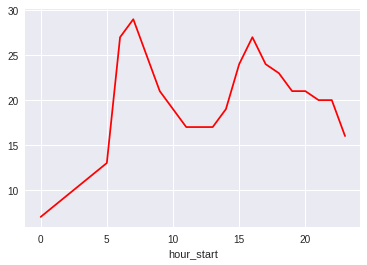

In [71]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

red_line.groupby("hour_start").trip_id.nunique().plot(color="red")
# orange_line.groupby("hour_start").trip_id.nunique().plot(color="orange")
# blue_line.groupby("hour_start").trip_id.nunique().plot(color="blue")

Now let's visualize the trip delays.

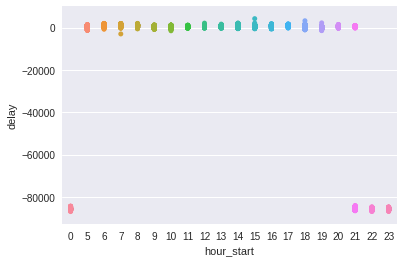

In [72]:
sns.stripplot(x="hour_start", y="delay", data=red_line)

Note that we're collapsing all the stops a trip makes into a line, so we can't distinguish between a train that leaves the first station late from a train that starts on time and gets progressively later the further it gets from its origin.

We can address this in a few ways.

We could take the mean delay of each trip:

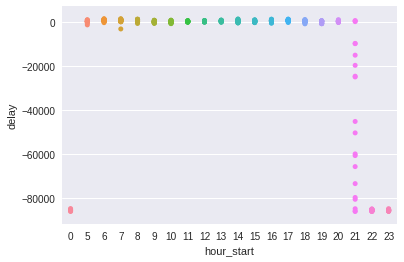

In [73]:
red_line_trips = red_line.groupby("trip_id")
red_line_trip_delays = pd.DataFrame({
    "delay": red_line_trips.delay.mean(), 
    "hour_start": red_line_trips.hour_start.first()})
sns.stripplot(x="hour_start", y="delay", data=red_line_trip_delays)

This gives an overall impression of how early or late entire trips are, but we can do better. We can use a heatmap to show the average lateness at each stop for each hour:

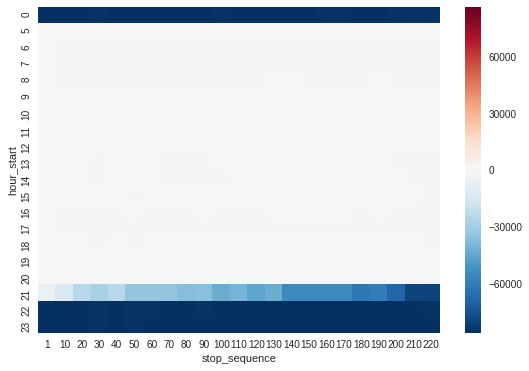

In [74]:
def reshape(stops):
    return stops.groupby("stop_sequence").delay.mean()

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(red_line.groupby("hour_start").apply(reshape), 
            ax=ax)
# orange_line.groupby("hour_start").apply(reshape)

We could also take a closer look at the trips for a particular hour. In particular, let's look at delays plotted against `stop_sequence`.

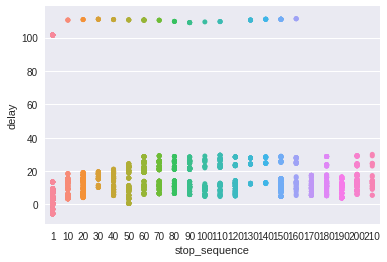

In [61]:
red_line_7 = red_line.query("hour_start == 7")
sns.stripplot(x="stop_sequence", 
              y="delay", 
              data=red_line_7)

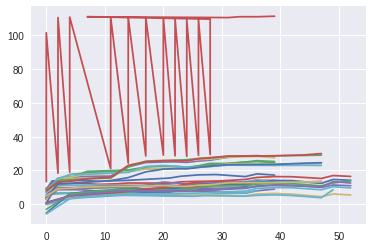

In [62]:
plt.figure(1)

for trip_id, stops in red_line_7.groupby("trip_id"):
    plt.plot(stops.schedule_offset/60, stops.delay, label=trip_id)

plt.show()

In [63]:
red_line_7_stops = red_line_7.groupby("stop_sequence").delay.describe()
red_line_7_stops.head()

,count,mean,std,min,25%,50%,75%,max
stop_sequence,,,,,,,,
1,528.0,10.024811,24.003073,-5.7,2.80,4.15,8.0,101.5
10,122.0,12.698361,16.250482,3.3,5.35,12.00,14.6,110.5
20,136.0,13.423529,15.373519,4.1,6.50,11.80,15.4,110.8
30,47.0,25.940426,29.805753,10.2,15.20,16.50,18.6,111.0
40,127.0,15.122047,17.949585,5.3,7.90,10.60,16.7,110.8


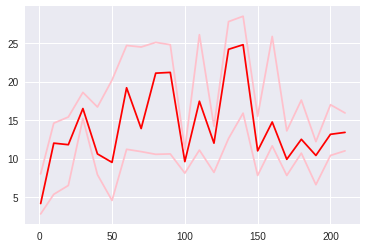

In [64]:
plt.figure(1)
plt.plot(red_line_7_stops["50%"], color="red")
plt.plot(red_line_7_stops["25%"], color="pink")
plt.plot(red_line_7_stops["75%"], color="pink")
plt.show()

This shows us the bounds of the middle 50 of the delays on red line trains starting between 7 and 8 am.

We can show the 

IndexError: ignored

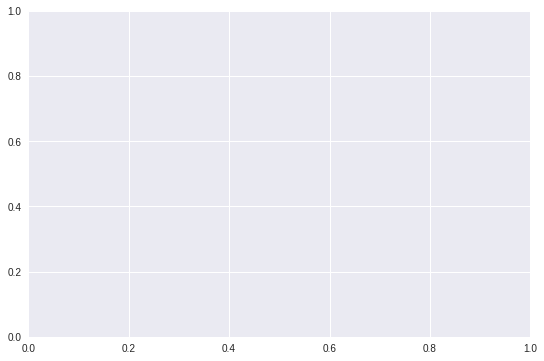

In [65]:
def reshape(stops):
    return stops.groupby("stop_sequence").delay.mean()

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(red_line.groupby("hour_start").apply(reshape), 
            ax=ax)

In [69]:
red_line_7.head()

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,lat,lon,arrival_time,route_id,direction_id,scheduled_arrival_time,delay,hour_start,schedule_offset
127636,35448339-L,2018-03-05,70094,50,54541867,STOPPED_AT,2018-03-05 07:05:38-05:00,42.28458,-71.063766,07:05:00,Red,1,2018-03-05 07:05:00-05:00,0.6,7,0.0
127637,35448339-L,2018-03-05,70094,50,54541867,STOPPED_AT,2018-03-05 07:05:38-05:00,42.28458,-71.063766,07:05:00,Red,1,2018-03-05 07:05:00-05:00,0.6,7,0.0
127638,35448339-L,2018-03-05,70094,50,54541867,STOPPED_AT,2018-03-05 07:05:38-05:00,42.28458,-71.063766,07:05:00,Red,1,2018-03-05 07:05:00-05:00,0.6,7,0.0
127639,35448339-L,2018-03-05,70094,50,54541867,STOPPED_AT,2018-03-05 07:05:38-05:00,42.28458,-71.063766,07:05:00,Red,1,2018-03-05 07:05:00-05:00,0.6,7,0.0
127640,35448339-L,2018-03-05,70094,50,54541867,STOPPED_AT,2018-03-05 07:05:38-05:00,42.28458,-71.063766,07:05:00,Red,1,2018-03-05 07:05:00-05:00,0.6,7,0.0


How about some readable stop names?

In [66]:
stop_info = get_zip_item(static_feed, "stops")
stop_info.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,wheelchair_boarding
0,Wareham Village,NaN,Wareham Village,NaN,41.758333,-70.714722,NaN,NaN,0,NaN,1
1,Buzzards Bay,NaN,Buzzards Bay,NaN,41.744805,-70.616226,NaN,NaN,0,NaN,1
2,Hyannis,NaN,Hyannis,NaN,41.660225,-70.276583,NaN,NaN,0,NaN,1
3,Logan-E,NaN,Logan Airport Terminal E,NaN,42.370022,-71.020754,NaN,NaN,0,NaN,1
4,Logan-Subway,NaN,Airport Subway Station,NaN,42.374699,-71.029831,NaN,NaN,0,NaN,1


In [77]:
red_line_stops_named = pd.merge(red_line_7, stop_info[["stop_id", "stop_name"]], on=["stop_id"])
red_line_stops_named.head()

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,lat,lon,arrival_time,route_id,direction_id,scheduled_arrival_time,delay,hour_start,schedule_offset,stop_name
0,35448339-L,2018-03-05,70094,50,54541867,STOPPED_AT,2018-03-05 07:05:38-05:00,42.28458,-71.063766,07:05:00,Red,1,2018-03-05 07:05:00-05:00,0.6,7,0.0,Ashmont - Inbound
1,35448339-L,2018-03-05,70094,50,54541867,STOPPED_AT,2018-03-05 07:05:38-05:00,42.28458,-71.063766,07:05:00,Red,1,2018-03-05 07:05:00-05:00,0.6,7,0.0,Ashmont - Inbound
2,35448339-L,2018-03-05,70094,50,54541867,STOPPED_AT,2018-03-05 07:05:38-05:00,42.28458,-71.063766,07:05:00,Red,1,2018-03-05 07:05:00-05:00,0.6,7,0.0,Ashmont - Inbound
3,35448339-L,2018-03-05,70094,50,54541867,STOPPED_AT,2018-03-05 07:05:38-05:00,42.28458,-71.063766,07:05:00,Red,1,2018-03-05 07:05:00-05:00,0.6,7,0.0,Ashmont - Inbound
4,35448339-L,2018-03-05,70094,50,54541867,STOPPED_AT,2018-03-05 07:05:38-05:00,42.28458,-71.063766,07:05:00,Red,1,2018-03-05 07:05:00-05:00,0.6,7,0.0,Ashmont - Inbound


AttributeError: ignored

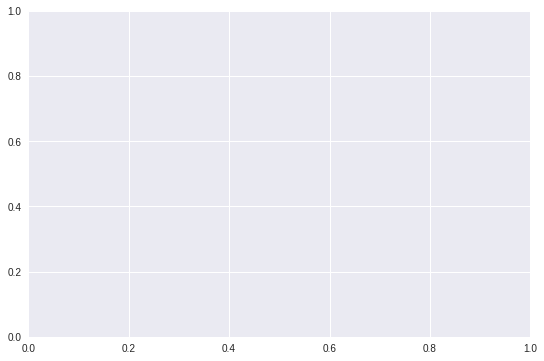

In [79]:
def reshape(stops):
    return stops.groupby("stop_sequence").delay.mean()

f, ax = plt.subplots(figsize=(9, 6))
reshaped_red_line_stops_named = red_line_stops_named.groupby("hour_start").apply(reshape)
# sns.heatmap(reshaped_red_line_stops_named, xticklabels=red_line
#             ax=ax
reshaped_red_line_stops_named.stop_name

In [73]:
routes = get_zip_item(static_feed, "routes")
routes.head()

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color,route_sort_order
0,CapeFlyer,3,NaN,CapeFLYER,NaN,2,http://capeflyer.com/,006595,FFFFFF,100
1,Logan-22,2,Shuttle,Massport Subway Shuttle (22),Airport Shuttle,3,NaN,NaN,NaN,2000022
2,Logan-33,2,Shuttle,Massport Subway Shuttle (33),Airport Shuttle,3,NaN,NaN,NaN,2000033
3,Logan-55,2,Shuttle,Massport Subway Shuttle (55),Airport Shuttle,3,NaN,NaN,NaN,2000055
4,Logan-66,2,Shuttle,Massport Subway / Ferry Terminal Shuttle (66),Airport Shuttle,3,NaN,NaN,NaN,2000066


In [0]:
routes[routes.agency_id == 2]

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color,route_sort_order
1,Logan-22,2,Shuttle,Massport Subway Shuttle (22),Airport Shuttle,3,NaN,NaN,NaN,2000022
2,Logan-33,2,Shuttle,Massport Subway Shuttle (33),Airport Shuttle,3,NaN,NaN,NaN,2000033
3,Logan-55,2,Shuttle,Massport Subway Shuttle (55),Airport Shuttle,3,NaN,NaN,NaN,2000055
4,Logan-66,2,Shuttle,Massport Subway / Ferry Terminal Shuttle (66),Airport Shuttle,3,NaN,NaN,NaN,2000066


In [0]:
# 
# recent_updates.head()
# trips
# recent_updates.trip_id = recent_updates.trip_id.str.strip()
# pd.merge(recent_updates, trips, on="trip_id")
recent_updates = get_updates(datetime.now() - timedelta(days=1))
recent_updates = pd.merge(recent_updates, trips, on="trip_id")

In [0]:
recent_updates.route_id.nunique()

194

In [0]:
grouped_routes = recent_updates.groupby("route_id")
distinct_trips = grouped_routes.trip_id.nunique()
distinct_updates = grouped_routes.count().trip_id

In [0]:
route_stats = pd.concat({"trips": distinct_trips, "updates": distinct_updates}, axis=1)
route_stats["updates per trip"] = route_stats["updates"]/route_stats["trips"]
route_stats.sort_values("updates", ascending=False)

NameError: name 'pd' is not defined

What is the relationship of tweet volume/minute and delays?

In [41]:
!pip install TwitterAPI

  Running setup.py bdist_wheel for TwitterAPI ... - \ done
  Stored in directory: /content/.cache/pip/wheels/b9/d4/30/5ede07ac4142224dbbb28b9a2eed35554e21c6bd6aa5e76755
Successfully built TwitterAPI


In [0]:
from TwitterAPI import TwitterAPI, TwitterRestPager
consumer_key = "iJcZc53yULImIO7P0GteQzkdy"
consumer_secret = "2BHrct9oTKpIQz6cVqoB5xqdA5KlbJ7hXLd5bEt8oKsU9f2tIu"
access_token = "928752949760872448-5P8U6z5SitlKKD1DJFy7t51a5pR8gKn"
access_token_secret = "zWf3afpJ1royeAy7jysqAUuEhHjyMqnHCoFh7nmmjbhZA"
api = TwitterAPI(consumer_key, consumer_secret, access_token, access_token_secret)

In [0]:
r = api.request("search/tweets", {"q": "@MBTA"})

In [44]:
# [status["text"] for status in r.json()["statuses"]]
r.json()["statuses"][0].keys()

dict_keys(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities', 'metadata', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'retweeted_status', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'lang'])

In [45]:
r.json()["statuses"][0]

{'contributors': None,
 'coordinates': None,
 'created_at': 'Wed Mar 07 01:44:24 +0000 2018',
 'entities': {'hashtags': [{'indices': [10, 15], 'text': 'MBTA'},
   {'indices': [16, 24], 'text': 'RedLine'}],
  'symbols': [],
  'urls': [],
  'user_mentions': [{'id': 150334831,
    'id_str': '150334831',
    'indices': [3, 8],
    'name': 'MBTA',
    'screen_name': 'MBTA'}]},
 'favorite_count': 0,
 'favorited': False,
 'geo': None,
 'id': 971199857342939137,
 'id_str': '971199857342939137',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'en',
 'metadata': {'iso_language_code': 'en', 'result_type': 'recent'},
 'place': None,
 'retweet_count': 1,
 'retweeted': False,
 'retweeted_status': {'contributors': None,
  'coordinates': None,
  'created_at': 'Wed Mar 07 01:36:21 +0000 2018',
  'entities': {'hashtags': [{'indices': [0, 5], 'text': 'M

In [0]:
from datetime import datetime
datetime.strptime("")
r.json()["statuses"][0]["created_at"]

TypeError: strptime() takes exactly 2 arguments (1 given)

In [0]:
"%a %b %d %H:%M:%S %z %Y"

api.request("statuses/filter", {"track": "@MBTA"})
for item in r:
    print(item)

{'created_at': 'Thu Nov 09 22:42:25 +0000 2017', 'id': 928754676799033346, 'id_str': '928754676799033346', 'text': 'Adding buses to the traffic does nothing positive! Build a train! Silver line sucks @MBTA https://t.co/4MY8CPiq5D', 'truncated': False, 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'MBTA', 'name': 'MBTA', 'id': 150334831, 'id_str': '150334831', 'indices': [84, 89]}], 'urls': [], 'media': [{'id': 928754670973177856, 'id_str': '928754670973177856', 'indices': [90, 113], 'media_url': 'http://pbs.twimg.com/media/DOOZc9bXUAARxy3.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DOOZc9bXUAARxy3.jpg', 'url': 'https://t.co/4MY8CPiq5D', 'display_url': 'pic.twitter.com/4MY8CPiq5D', 'expanded_url': 'https://twitter.com/MattSheehan1985/status/928754676799033346/photo/1', 'type': 'photo', 'sizes': {'large': {'w': 575, 'h': 1024, 'resize': 'fit'}, 'medium': {'w': 575, 'h': 1024, 'resize': 'fit'}, 'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'sma

In [0]:
datetime.strptime("Thu Nov 09 22:42:25 -0000 2017", "%a %b %d %H:%M:%S %z %Y"
                 )

datetime.datetime(2017, 11, 9, 22, 42, 25, tzinfo=datetime.timezone.utc)

In [0]:
import pytz
help(pytz)

Help on package pytz:

NAME
    pytz

DESCRIPTION
    datetime.tzinfo timezone definitions generated from the
    Olson timezone database:
    
        ftp://elsie.nci.nih.gov/pub/tz*.tar.gz
    
    See the datetime section of the Python Library Reference for information
    on how to use these modules.

PACKAGE CONTENTS
    exceptions
    lazy
    reference
    tzfile
    tzinfo

CLASSES
    builtins.Exception(builtins.BaseException)
        pytz.exceptions.InvalidTimeError
            pytz.exceptions.AmbiguousTimeError
            pytz.exceptions.NonExistentTimeError
    builtins.KeyError(builtins.LookupError)
        pytz.exceptions.UnknownTimeZoneError
    
    class AmbiguousTimeError(InvalidTimeError)
     |  Exception raised when attempting to create an ambiguous wallclock time.
     |  
     |  At the end of a DST transition period, a particular wallclock time will
     |  occur twice (once before the clocks are set back, once after). Both
     |  possibilities may be correct,